In [1]:
import torch
import h5py
import numpy as np
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
from sklearn.preprocessing import normalize
from scipy.sparse import lil_matrix, csr_matrix, hstack
from tqdm import tqdm
import math

In [2]:
# 변수 선언 block
train_rec_file_list = ["./final_recs/Chanho_recs/train_recs/CF_rec_cpl_dim_64.pickle",
                       "./final_recs/Chanho_recs/train_recs/Graph_rec_cpl_1_2_depth_5.pickle",
                       "./final_recs/Chanho_recs/train_recs/Graph_rec_cpl_1_4_depth_3.pickle",
                       "./final_recs/Chanho_recs/train_recs/Graph_rec_cpl_1_8_depth_3.pickle",
                       "./final_recs/Chanho_recs/train_recs/Graph_rec_cpl_1_8_depth_1.pickle",
                       "./final_recs/Junwon_recs/inference_train_completion_DNN_fc_layer_sizes_1024-1024-512-512_batch_16_seed_0.pkl",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncFC_PoolPMA_CplPooled_NumEnc5_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncFC_PoolPMA_CplPooled_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncFC_PoolPMA_CplPooled_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec0_Hid512_Emb512_Ind16.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind6.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind7.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc4_NumDec3_Hid512_Emb512_Ind6.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc6_NumDec0_Hid512_Emb512_Ind29.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc4_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc6_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_train_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                      ]

valid_rec_file_list = ["./final_recs/Chanho_recs/valid_recs/CF_rec_cpl_dim_64.pickle",
                       "./final_recs/Chanho_recs/valid_recs/Graph_rec_cpl_1_2_depth_5.pickle",
                       "./final_recs/Chanho_recs/valid_recs/Graph_rec_cpl_1_4_depth_3.pickle",
                       "./final_recs/Chanho_recs/valid_recs/Graph_rec_cpl_1_8_depth_3.pickle",
                       "./final_recs/Chanho_recs/valid_recs/Graph_rec_cpl_1_8_depth_1.pickle",
                       "./final_recs/Junwon_recs/inference_valid_cpl_completion_DNN_fc_layer_sizes_1024-1024-512-512_batch_16_seed_0.pkl",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncFC_PoolPMA_CplPooled_NumEnc5_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncFC_PoolPMA_CplPooled_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncFC_PoolPMA_CplPooled_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec0_Hid512_Emb512_Ind16.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind6.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind7.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc3_NumDec3_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc4_NumDec3_Hid512_Emb512_Ind6.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_PoolPMA_CplPooled_NumEnc6_NumDec0_Hid512_Emb512_Ind29.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc4_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc6_NumDec0_Hid512_Emb512_Ind10.pickle",
                       "./final_recs/Hanseul_recs/rec_CCNet_valid_cpl_EncHYBRID_SA_PoolPMA_CplEncoded_NumEnc8_NumDec0_Hid512_Emb512_Ind10.pickle",
                      ]

train_path = '../Hanseul/Container/train_cpl'

valid_path = './Container/valid_cpl'

state_dict_save_path = "./ensemble_model/ensemble_model_best_cpl.pt"

loss_fig_path = "./ensemble_model/ensemble_cpl_loss.png"
acc_fig_path = "./ensemble_model/ensemble_cpl_acc.png"

epochs = 20

In [3]:
class RecDataset(Dataset):
    def __init__(self, recs_list, answer_dict, query_num, item_num, transform=None, target_transform=None):
        # rec_matrix = [query num, model_num, item_num]
        self.rec_matrix = []
        for i in range(query_num):
            self.rec_matrix.append(lil_matrix((len(recs_list), item_num)))
        for i, recs in enumerate(recs_list):
            for query in tqdm(recs.keys()):
                rec = recs[query]
                rec_items, rec_scores = [rec_ for rec_, score in rec], [score for rec_, score in rec]
                rec_scores = normalize(np.array(rec_scores)[:,np.newaxis], axis=0).ravel()
                for item, score in zip(rec_items, rec_scores):
                    self.rec_matrix[query][i, item] = score
        self.labels = answer_dict
        self.transform = transform
        self.target_transform = target_transform
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.rec_matrix)

    def __getitem__(self, idx):
        rec_matrix = self.rec_matrix[idx].toarray()
        label = self.labels[idx]
        if self.transform:
            rec_matrix = self.transform(rec_matrix).to(self.device)
        if self.target_transform:
            label = self.target_transform(label)
        return rec_matrix.to(self.device), label.to(self.device)

In [4]:
class Network(nn.Module):
    def __init__(self, model_len, k=10):
        super(Network, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(k, model_len))
        self.w2 = torch.nn.Parameter(torch.randn(1, k))
        
    def forward(self, x):
        #import ipdb; ipdb.set_trace()
        x = x.float()
        x = torch.einsum('nm, bmp -> bnp', self.w1, x)
        x = torch.einsum('nm, bmp -> bnp', self.w2, x).squeeze(1)
        return x

In [5]:
recs_list = []
for rec_file in train_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 6714

h5f_valid = h5py.File(train_path, 'r')
answer = h5f_valid['labels_id'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

train_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
###############
recs_list = []
for rec_file in valid_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 6714

h5f_valid = h5py.File(valid_path, 'r')
answer = h5f_valid['labels_id'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

test_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 8662.24it/s]


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network(len(train_rec_file_list), k=50).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader),total=len(dataloader)):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * int(X.size(0))
    avg_loss = total_loss / size
    print(f"Train loss: {avg_loss:>7f}")
    return avg_loss
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * int(X.size(0))
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
        
train_loss_lst = []
test_loss_lst = []
test_acc_lst = []
min_test_acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
    if test_acc > min_test_acc:
        min_test_acc = test_acc
        torch.save(model.state_dict(), state_dict_save_path)
        print("save")
print("Done!")

Epoch 1
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:05<00:00,  9.31it/s]


Train loss: 7.932956


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.93it/s]


Test Error: 
 Accuracy: 15.84%, Avg loss: 7.220156 

save
Epoch 2
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:05<00:00,  9.32it/s]


Train loss: 6.197403


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.95it/s]


Test Error: 
 Accuracy: 15.81%, Avg loss: 7.095982 

Epoch 3
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:06<00:00,  9.29it/s]


Train loss: 6.153125


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00, 10.08it/s]


Test Error: 
 Accuracy: 15.77%, Avg loss: 7.076456 

Epoch 4
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [06:57<00:00,  9.48it/s]


Train loss: 6.151807


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  8.79it/s]


Test Error: 
 Accuracy: 15.83%, Avg loss: 7.087101 

Epoch 5
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:12<00:00,  9.15it/s]


Train loss: 6.151422


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  9.44it/s]


Test Error: 
 Accuracy: 15.77%, Avg loss: 7.089614 

Epoch 6
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:06<00:00,  9.29it/s]


Train loss: 6.151321


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  9.33it/s]


Test Error: 
 Accuracy: 15.93%, Avg loss: 7.096017 

save
Epoch 7
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [05:47<00:00, 11.38it/s]


Train loss: 6.151238


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:11<00:00, 10.51it/s]


Test Error: 
 Accuracy: 15.79%, Avg loss: 7.083079 

Epoch 8
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [06:58<00:00,  9.47it/s]


Train loss: 6.151236


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.54it/s]


Test Error: 
 Accuracy: 15.95%, Avg loss: 7.108358 

save
Epoch 9
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:02<00:00,  9.38it/s]


Train loss: 6.151138


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.53it/s]


Test Error: 
 Accuracy: 15.91%, Avg loss: 7.089396 

Epoch 10
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [06:58<00:00,  9.47it/s]


Train loss: 6.151144


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.70it/s]


Test Error: 
 Accuracy: 15.94%, Avg loss: 7.096693 

Epoch 11
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:00<00:00,  9.42it/s]


Train loss: 6.151176


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.85it/s]


Test Error: 
 Accuracy: 15.91%, Avg loss: 7.104781 

Epoch 12
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:00<00:00,  9.41it/s]


Train loss: 6.151093


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00, 10.15it/s]


Test Error: 
 Accuracy: 15.95%, Avg loss: 7.100632 

Epoch 13
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:01<00:00,  9.40it/s]


Train loss: 6.151154


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00, 10.23it/s]


Test Error: 
 Accuracy: 15.86%, Avg loss: 7.099558 

Epoch 14
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:03<00:00,  9.34it/s]


Train loss: 6.151013


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:13<00:00,  9.42it/s]


Test Error: 
 Accuracy: 15.85%, Avg loss: 7.085788 

Epoch 15
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:16<00:00,  9.08it/s]


Train loss: 6.151128


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00,  9.84it/s]


Test Error: 
 Accuracy: 15.88%, Avg loss: 7.089069 

Epoch 16
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [07:08<00:00,  9.24it/s]


Train loss: 6.151098


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:12<00:00, 10.22it/s]


Test Error: 
 Accuracy: 15.84%, Avg loss: 7.110071 

Epoch 17
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [05:00<00:00, 13.18it/s]


Train loss: 6.151151


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 38.37it/s]


Test Error: 
 Accuracy: 15.94%, Avg loss: 7.099613 

Epoch 18
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [01:54<00:00, 34.50it/s]


Train loss: 6.151071


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 33.39it/s]


Test Error: 
 Accuracy: 15.91%, Avg loss: 7.092545 

Epoch 19
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [01:50<00:00, 35.75it/s]


Train loss: 6.151104


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 38.38it/s]


Test Error: 
 Accuracy: 15.97%, Avg loss: 7.119531 

save
Epoch 20
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [02:11<00:00, 30.05it/s]


Train loss: 6.151132


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:03<00:00, 34.54it/s]

Test Error: 
 Accuracy: 15.88%, Avg loss: 7.093473 

Done!


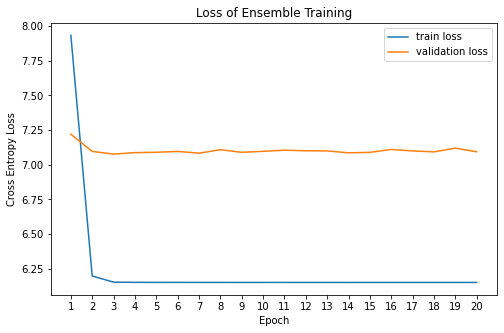

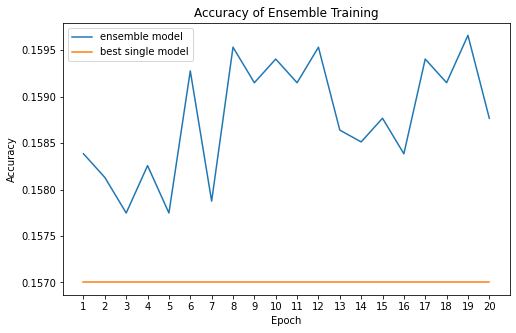

In [7]:
import matplotlib.pyplot as plt
epoch_lst = list(range(1, epochs+1))
plt.figure(figsize=(8,5))
plt.title("Loss of Ensemble Training")
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(epoch_lst)
plt.plot(epoch_lst, train_loss_lst, label='train loss')
plt.plot(epoch_lst, test_loss_lst, label = 'validation loss')
plt.legend()
plt.savefig(loss_fig_path)
plt.show()

max_val = 0.157
plt.figure(figsize=(8,5))
plt.title("Accuracy of Ensemble Training")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_lst)
plt.plot(epoch_lst, test_acc_lst, label='ensemble model')
plt.plot(epoch_lst, [max_val]*epochs, label='best single model')
plt.legend()
plt.savefig(acc_fig_path)
plt.show()